In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Experiments

All models were trained on fold 2 of the AD-DC data

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 0

# baseline: 
exp_base = {2: "20180328_10_53_16_dcnnv1_150000E_lr2e02",
            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
exp_base_path = os.path.join(LOG_DIR, exp_base[TEST_FOLD])

# baseline with BRIER LOSS:
exp_base_brier = {2: "",
                  0: "20180425_14_29_45_dcnnv1_150000E_lr2e04"}
exp_base_brier_path = os.path.join(LOG_DIR, exp_base_brier[TEST_FOLD])



# MC dropout models
# Fold 2: 
# Fold 0: 20180413_16_36_58_dcnn_mcv1_150000E_lr2e02
exp_mc005 = {2: "",
             0: "20180413_16_36_58_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_model = os.path.join(LOG_DIR, exp_mc005[TEST_FOLD])

# MC dropout models
# Fold 2: 
# Fold 0: 20180413_16_36_58_dcnn_mcv1_150000E_lr2e02
exp_mc01 = {2: "20180420_11_59_43_dcnn_mcv1_150000E_lr2e02",
            0: "20180416_08_25_43_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_path = os.path.join(LOG_DIR, exp_mc01[TEST_FOLD])

# MC dropout models
# Fold 2: 
# Fold 0: 20180423_16_23_00_dcnn_mcv1_150000E_lr2e02
exp_mc015 = {2: "",
            0: "20180423_16_23_00_dcnn_mcv1_150000E_lr2e02"}
exp_mc015_path = os.path.join(LOG_DIR, exp_mc015[TEST_FOLD])



# Fold 2: 
# Fold 0: 20180416_08_25_43_dcnn_mcv1_150000E_lr2e02
# exp_mc01 = {2: "",
#            0: "20180416_08_25_43_dcnn_mcv1_150000E_lr2e02"}
# exp_mc01_model = os.path.join(LOG_DIR, exp_mc01[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180418_15_02_36_dcnn_mcv1_150000E_lr2e02
exp_mc005_brier = {2: "",
                   0: "20180418_15_02_36_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_brier_path = os.path.join(LOG_DIR, exp_mc005_brier[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180418_15_02_05_dcnn_mcv1_150000E_lr2e02
exp_mc01_brier = {2: "20180420_12_00_23_dcnn_mcv1_150000E_lr2e04",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])

exp_mc015_brier = {2: "",
                   0: "20180423_16_22_19_dcnn_mcv1_150000E_lr2e04"}
exp_mc015_brier_path = os.path.join(LOG_DIR, exp_mc015_brier[TEST_FOLD])

## Load experimental data and test data set

In [3]:
print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_base = ExperimentHandler.load_experiment(exp_base_path)
exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)
exper_hdl_base.set_model_name("DCNN baseline fold-{}".format(exper_hdl_base.exper.run_args.fold_ids[0]))
print("Model name {}".format(exper_hdl_base.exper.model_name))


exper_base_brier = ExperimentHandler.load_experiment(exp_base_brier_path)
exper_hdl_base_brier = ExperimentHandler(exper_base_brier, use_logfile=False)
exper_hdl_base_brier.set_root_dir(ROOT_DIR)
exper_hdl_base_brier.set_model_name("DCNN baseline-brier fold-{}".format(
                                    exper_hdl_base_brier.exper.run_args.fold_ids[0]))
print("Model name {}".format(exper_hdl_base_brier.exper.model_name))


exper_mc005 = ExperimentHandler.load_experiment(exp_mc005_model)
exper_hdl_mc005 = ExperimentHandler(exper_mc005, use_logfile=False)
exper_hdl_mc005.set_root_dir(ROOT_DIR)
exper_hdl_mc005.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc005.exper.run_args.fold_ids[0],
    exper_hdl_mc005.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005.exper.model_name))


exper_mc005_brier = ExperimentHandler.load_experiment(exp_mc005_brier_path)
exper_hdl_mc005_brier = ExperimentHandler(exper_mc005_brier, use_logfile=False)
exper_hdl_mc005_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc005_brier.set_model_name("MC-dropout-brier fold-{} (p={})".format(
                                     exper_hdl_mc005_brier.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_brier.exper.model_name))


exper_mc01 = ExperimentHandler.load_experiment(exp_mc01_path)
exper_hdl_mc01 = ExperimentHandler(exper_mc01, use_logfile=False)
exper_hdl_mc01.set_root_dir(ROOT_DIR)
exper_hdl_mc01.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc01.exper.run_args.fold_ids[0],
    exper_hdl_mc01.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01.exper.model_name))


exper_mc015 = ExperimentHandler.load_experiment(exp_mc015_path)
exper_hdl_mc015 = ExperimentHandler(exper_mc015, use_logfile=False)
exper_hdl_mc015.set_root_dir(ROOT_DIR)
exper_hdl_mc015.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc015.exper.run_args.fold_ids[0],
    exper_hdl_mc015.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc015.exper.model_name))

exper_mc01_brier = ExperimentHandler.load_experiment(exp_mc01_brier_path)
exper_hdl_mc01_brier = ExperimentHandler(exper_mc01_brier, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01_brier.exper.model_name))

exper_mc015_brier = ExperimentHandler.load_experiment(exp_mc015_brier_path)
exper_hdl_mc015_brier = ExperimentHandler(exper_mc015_brier, use_logfile=False)
exper_hdl_mc015_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc015_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc015_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc015_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc015_brier.exper.model_name))

try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc01.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True)

  0%|          | 0/25 [00:00<?, ?it/s]

!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 0
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_39_dcnnv1_150000E_lr2e02/stats/exper_stats.dll
Model name DCNN baseline fold-0
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180425_14_29_45_dcnnv1_150000E_lr2e04/stats/exper_stats.dll
Model name DCNN baseline-brier fold-0
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180413_16_36_58_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_36_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-brier fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180416_08_25_43_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.1)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180423_16_23_00_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name M

100%|██████████| 25/25 [00:01<00:00, 16.96it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


## Run model evaluation of test set

In [37]:
mc_samples = 1
sample_weights = False
store_details = False
image_range = None # [10, 24] #  [24]
if sample_weights:
    generate_stats = True
else:
    generate_stats = False
save_results = False
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = True
referral_threshold = 0.15
ref_positives_only = True

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,)


    
print("Ready")

WARNING - Using uncertainty maps to refer pixels. Threshold 0.15
Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/checkpoints
Evaluating model MC-dropout brier fold-0 (p=0.1) - runID 1
INFO - Running test on 25 images with model from checkpoint 150000
Ref% ES/ED 33.98/27.08 - Absolute error reduction 3061.00/1616.00 
Image 1-patient016 - test loss -2.261  dice(RV/Myo/LV):	ES 0.87/0.85/0.96	ED 0.94/0.85/0.97
					 After referral		ES 0.94/0.92/0.97	ED 0.95/0.92/0.97
					Hausdorff(RV/Myo/LV):	ES 12.52/10.00/10.00	ED 25.36/10.10/10.85
					After referral:		ES 12.52/10.00/7.54	ED 25.36/10.10/5.05
Ref% ES/ED 40.15/23.91 - Absolute error reduction 1591.00/1249.00 
Image 2-patient017 - test loss -3.394  dice(RV/Myo/LV):	ES 0.93/0.86/0.97	ED 0.96/0.84/0.97
					 After referral		ES 0.94/0.92/0.98	ED 0.97/0.89/0.98
					Hausdorff(RV/Myo/LV):	ES 10.00/16.33/15.08	ED 10.76/16.92/14.00
					After referral:		ES 10.00/4.

Ref% ES/ED 40.45/23.93 - Absolute error reduction 2179.00/1783.00 
Image 24-patient099 - test loss -1.555  dice(RV/Myo/LV):	ES 0.90/0.88/0.92	ED 0.96/0.89/0.97
					 After referral		ES 0.92/0.93/0.95	ED 0.98/0.92/0.98
					Hausdorff(RV/Myo/LV):	ES 9.90/11.09/10.17	ED 7.00/8.85/5.00
					After referral:		ES 8.01/6.53/7.00	ED 6.53/5.38/3.13
Ref% ES/ED 51.22/41.07 - Absolute error reduction 596.00/570.00 
Image 25-patient100 - test loss -1.327  dice(RV/Myo/LV):	ES 0.86/0.92/0.94	ED 0.94/0.91/0.96
					 After referral		ES 0.88/0.95/0.97	ED 0.95/0.94/0.98
					Hausdorff(RV/Myo/LV):	ES 10.48/5.05/2.80	ED 10.38/10.19/3.13
					After referral:		ES 10.48/4.20/2.80	ED 10.38/3.13/3.13
------------------------------------------------------------------------------------------------
Overall:	dice(RV/Myo/LV): ES 0.88 (0.05)/0.89 (0.03)/0.92 (0.08)	ED 0.94 (0.04)/0.88 (0.03)/0.96 (0.02)
After referral:			 ES 0.93 (0.04)/0.93 (0.03)/0.94 (0.08)	ED 0.96 (0.02)/0.92 (0.02)/0.97 (0.02)
Hausdorff(RV/Myo/LV

In [ ]:
Overall:	dice(RV/Myo/LV): ES 0.88 (0.05)/0.89 (0.03)/0.92 (0.08)	ED 0.94 (0.04)/0.88 (0.03)/0.96 (0.02)
After referral:			 ES 0.91 (0.04)/0.92 (0.03)/0.93 (0.08)	ED 0.95 (0.02)/0.90 (0.02)/0.97 (0.02)
Hausdorff(RV/Myo/LV):	ES 14.01 (7.39)/10.80 (6.25)/9.25 (5.14)	ED 13.23 (9.93)/8.94 (4.34)/6.97 (3.67)
After referral:		ES 13.77 (7.52)/9.68 (5.97)/8.34 (5.26)	ED 12.42 (9.04)/7.66 (4.41)/6.50 (3.50)
Ref ES %: 26.43 (std=16.38,med=22.54)	Red%: 24.31 (std=21.22,med=20.81)	PR/RC 0.35 (0.31)/0.31 (0.28)
Ref ED %: 16.86 (std=13.92,med=12.60)	Red%: 19.96 (std=16.23,med=17.49)	PR/RC 0.29 (0.25)/0.22 (0.20)

In [7]:
exper_handler.test_results.show_results()

------------------------------------------------------------------------------------------------
Overall:	dice(RV/Myo/LV): ES 0.86 (0.00)/0.92 (0.00)/0.95 (0.01)	ED 0.95 (0.01)/0.90 (0.01)/0.97 (0.01)
After referral:			 ES 0.90 (0.03)/0.94 (0.00)/0.96 (0.01)	ED 0.97 (0.00)/0.94 (0.01)/0.98 (0.00)
Hausdorff(RV/Myo/LV):	ES 11.69 (1.21)/9.05 (4.01)/6.40 (3.60)	ED 10.14 (0.24)/13.61 (3.42)/4.09 (0.96)
After referral:		ES 11.69 (1.21)/4.62 (0.42)/2.97 (0.17)	ED 7.10 (2.90)/10.11 (6.98)/2.97 (0.17)
Ref ES %: 0.82 (std=0.49,med=0.84)	Red%: 36.97 (std=30.88,med=32.74)	PR/RC 0.40 (0.35)/0.37 (0.31)
Ref ED %: 2.96 (std=3.66,med=1.31)	Red%: 44.19 (std=27.43,med=35.50)	PR/RC 0.12 (0.12)/0.41 (0.27)


In [ ]:
exper_handler = exper_hdl_mc005

image_ids = exper_handler.test_results.image_ids

image_range = None
u_type = "stddev"

analyze_slices(exper_handler, image_range=image_range, do_save=False, do_show=True, u_type=u_type,
               translate_img_range=True)

# Compare performance of models

In [9]:
image_range = [24]

for img_idx in image_range:
    exper_handler.test_results.visualize_uncertainty_stats(image_num=img_idx, width=16, height=10, 
                                                     info_type="probs",
                                                     do_save=True, do_show=False,
                                                     model_name=exper_handler.exper.model_name)

ES correct/error(fp+fn) (447353,) / (7519,)
ED correct/error(fp+fn) (441197,) / (7837,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180416_08_25_43_dcnn_mcv1_150000E_lr2e02/figures/patient100/probs_densities_mc5_False.png


[24]
Rows/columns 14/4


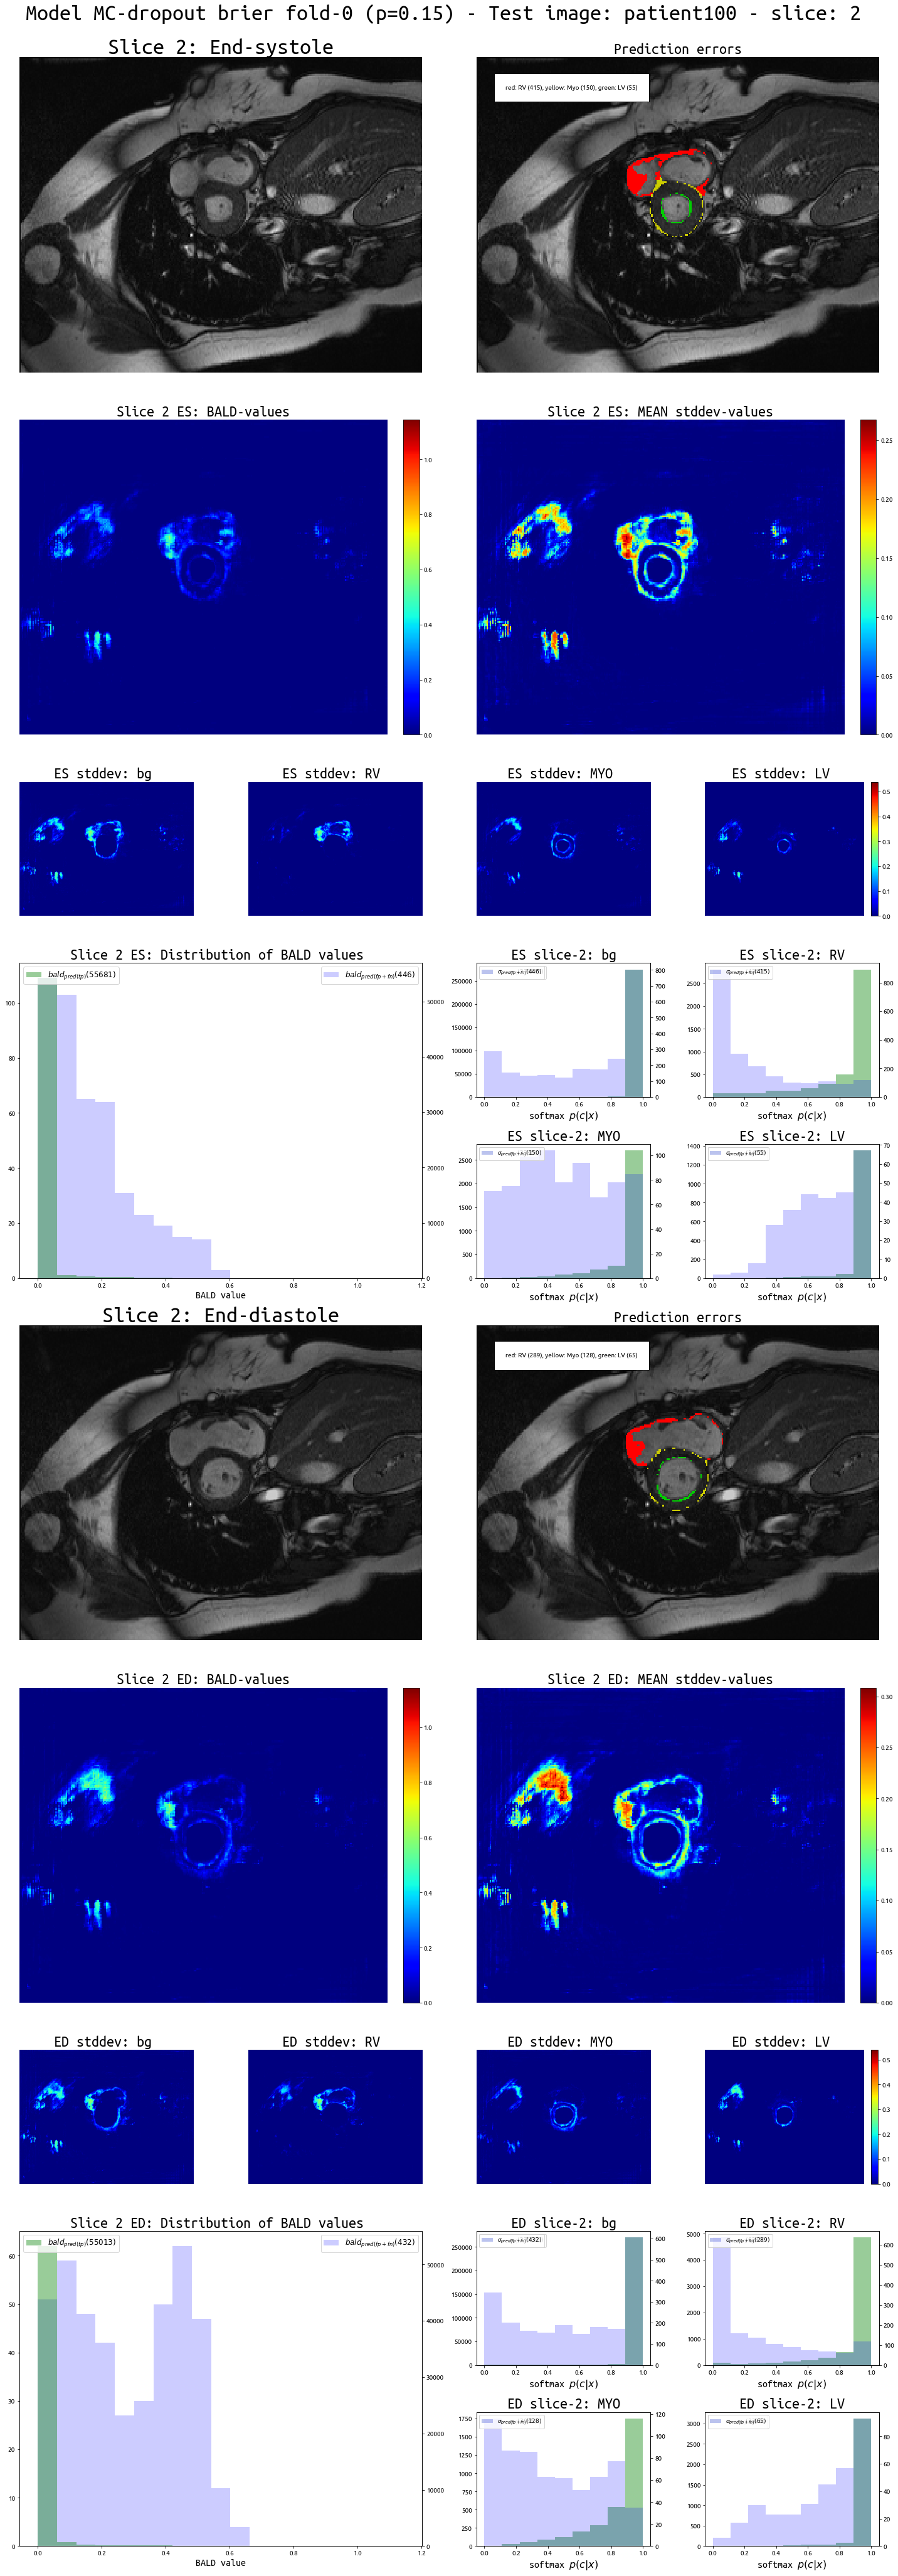

INFO - Ready!


In [58]:
# model_name a) Baseline  b) MC-dropout 0.1

model_name = exper_handler.exper.model_name
errors_only = False  # in case of the BASELINE model we only want the seg-errors
image_range = [24]
if image_range is None:
    image_range = np.arange(len(exper_handler.test_results.image_names))

print(image_range)
for image_num in image_range:
    exper_handler.test_results.visualize_uncertainty_histograms(image_num=image_num, width=20, height=60, 
                                                                 info_type="probs",
                                                                 do_save=False, slice_range=[1],
                                                                 std_threshold=0., errors_only=errors_only, 
                                                                 do_show=True, use_bald=True,
                                                                 model_name = model_name)
                                                                 # uncertainty
    print("INFO - Ready!")


In [ ]:
exper_hdl_mc01.test_results.visualize_test_slices(width=20, height=80, slice_range=[0, 5],
                                               do_save=False, image_num=0)

In [ ]:
exper_handler = exper_hdl_mc005_bs
exper_handler.test_results.visualize_prediction_uncertainty(width=20, height=25, slice_range=np.arange(10), 
                                                            do_save=True, std_threshold=None, 
                                                            image_num=0)

In [ ]:
Test img/slice 24/5 	ES: Dice (RV/Myo/LV)*0.84*/*0.90*/*0.95*	ED: dice (RV/Myo/LV)*0.89*/0.88/*0.97*
Test img/slice 24/6 	ES: Dice (RV/Myo/LV)*0.94*/*0.91*/*0.88*	ED: dice (RV/Myo/LV)*0.97*/0.82/*0.95*
Test img/slice 24/7 	ES: Dice (RV/Myo/LV)*0.77*/*0.68*/*0.77*	ED: dice (RV/Myo/LV)*0.93*/*0.76*/*0.90*
Test img/slice 24/8 	ES: Dice (RV/Myo/LV)*0.00*/*0.00*/*0.00*	ED: dice (RV/Myo/LV)*0.63*/*0.00*/*0.00*

In [31]:
exper_handler.test_results.test_accuracy_slices[24][:, 1:, 7]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.32285115,  0.        ,  0.        ]])